In [1]:
from typing import Annotated, Literal

from langgraph.graph import END, MessagesState, START, StateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from IPython.display import Image, display

### Tools

In [3]:
tavily_tool = TavilySearch(max_results=5)


In [4]:
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### Graph

In [5]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [6]:
llm = ChatOpenAI(model='gpt-4o')

In [7]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [ ]:
# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague"
    ),
)



def research_node(
    state: MessagesState,
) -> Command[Literal['chart_generator', END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result['messages'][-1], 'chart_generator')
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result['messages'][-1] = HumanMessage(
        content=result['messages'][-1].content, name='researcher'
    )
    print("Research node:", result['messages'][-1].content)
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result['messages'],
        },
        goto=goto
    )

In [ ]:
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with researcher colleague"
    ),
)

def chart_node(state: MessagesState) -> Command[Literal['researcher', END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result['messages'][-1], 'researcher')
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result['messages'][-1] = HumanMessage(
        content=result['messages'][-1].content, name='chart_generator'
    )
    print("Chart node:", result['messages'][-1].content)
    return Command(
        update={
            # shared internal message history of chart agent with other agents
            "messages": result['messages']
        },
        goto=goto,
    )

### Define the Graph

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

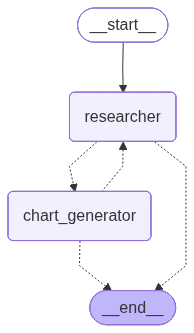

In [11]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### Invoke

Research node: I have obtained the GDP data for the UK over the past 5 years. Here is the information in a structured format:

- 2019: $2.851 trillion
- 2020: $2.697 trillion
- 2021: $3.143 trillion
- 2022: $3.114 trillion
- 2023: $3.381 trillion

Unfortunately, I am unable to create the chart myself, but I will forward this data to a colleague who can generate the line chart for you.
{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chat of itOne you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='22e9eb2a-6288-49d5-ace1-0dd6c5334e39'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5xLw8TnadYShqLoG3CRSgeX1', 'function': {'arguments': '{"query":"UK GDP data for past 5 years"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1396, 'total_tokens': 1419, 'completion_tokens_details':

Python REPL can execute arbitrary code. Use with caution.


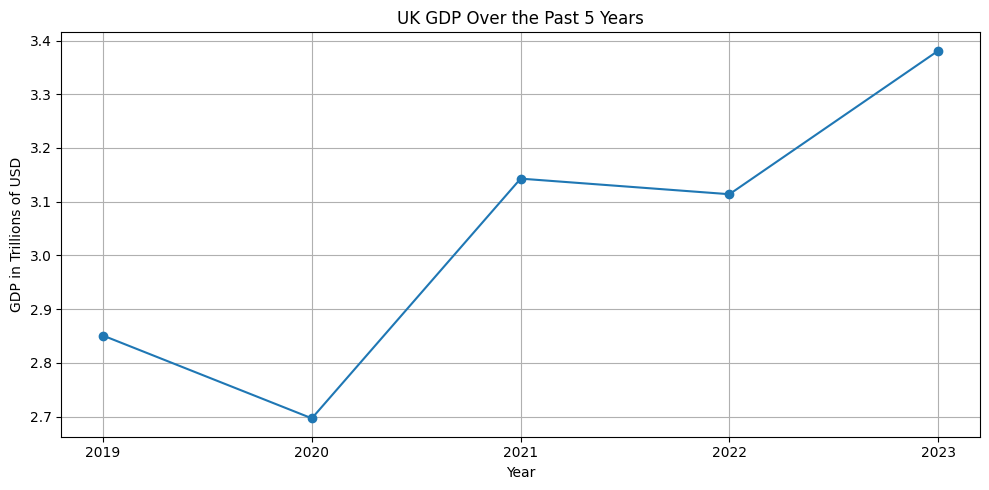

Chart node: I have created the line chart depicting the GDP of the UK over the past 5 years. The chart illustrates the changes in GDP from 2019 to 2023, showing a steady recovery after the decline in 2020.

FINAL ANSWER: The line chart of the UK's GDP over the past 5 years has been successfully generated.
{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chat of itOne you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='22e9eb2a-6288-49d5-ace1-0dd6c5334e39'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5xLw8TnadYShqLoG3CRSgeX1', 'function': {'arguments': '{"query":"UK GDP data for past 5 years"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1396, 'total_tokens': 1419, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,

In [13]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chat of it"
                "One you make the chart, finish."
            ),
            
        ]
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150}
)
for s in events:
    print(s)
    print("-----")